In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
import numpy as np
import tqdm
import os
import time
import re
import pandas as pd
import string
import gensim
import time
import random
import collections
from collections import Counter
from nltk.corpus import stopwords
from itertools import chain
from sklearn import manifold
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

下面的代码是配置本地环境，用于colab的代码


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [4]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
# 指定当前的工作文件夹
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Colab Notebooks") 

至此colab链接上谷歌云盘，本地环境配置完成
下面进行字符级词向量训练

In [ ]:
data=pd.read_csv("data0.csv", usecols=['text']) #本地文件，约44万条未标注微博文本

In [ ]:
x_data=data['text'].values.tolist()

In [ ]:
for i, sentence in enumerate(x_data):
  x_data[i] = [ch.strip().strip('*').strip('=').replace(' ','').replace('\t','').replace('\n','') for ch in sentence]

NameError: ignored

In [ ]:
from gensim.models.word2vec import Word2Vec 
model = Word2Vec(x_data, size=200, min_count=10, window=8, sg=0) # default value is 5
model.save('weibo_zh.model') 

下面测试一下词向量模型

In [6]:
import gensim
model = gensim.models.Word2Vec.load('weibo_zh.Model')
#查看某个字词的向量：
print(model['病'])
#查看与该词最接近的其他词汇及相似度：
print(model.most_similar(['数']))
#查看两个词之间的相似度：
model.similarity('数','值')

[-2.28191     1.3653474  -0.16083604  1.7539886   1.7753583  -2.8924189
 -6.7572083  -5.6665354  -4.489135   -4.373437    0.19171126  6.6604376
  2.3583348  -0.9761446  -0.9280778  -0.3411735  -6.363898    3.0069475
 -1.8966385  -0.98035264 -0.43076777 -1.7283145   7.7311997   2.9326515
 -8.675373    0.4605924  -4.5411534  -0.6688158  -1.0710291   9.204415
  1.4448801  -0.18904945 -1.0875466  -2.4821107  -0.11731756 -4.688062
 -1.83492     1.8941717  -1.2240412   3.997795   -6.131862   -0.84516597
  0.379602    1.6169198  -1.0874683   1.4507201   1.9144319  -2.9215953
 -2.2150564   7.041685    2.1402578  -0.75378007  3.9061177   0.73607546
 -5.7312818   2.3644204  -3.2974834  -0.4703504  -1.8109761  -3.7888265
  0.36021924 -6.069605   -3.1552513  -2.5458043  -3.3931525   6.2398133
  3.7134507   1.6498202  -1.2904626   3.145252    3.8952723   2.6029856
  1.5863794  -4.022904   -4.583324    4.738867    1.4096162  -7.364059
 -0.5454828   0.576546   -7.3758125   2.8207383   2.5559213   4.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.023238918

下面进入CNN模型

In [124]:
wvmodel=gensim.models.Word2Vec.load("weibo_zh.model").wv # 这是上面的词向量模型

In [125]:
data=pd.read_csv("labeledData.csv",usecols=['review','label'])

In [126]:
x_data=data['review'].values.tolist()
for i, sentence in enumerate(x_data):
  x_data[i] = [ch.strip().strip('*').strip('=').replace(' ','').replace('\t','').replace('\n','') for ch in sentence]

In [127]:
y_data=data['label'].values.tolist()
labels = len(set(y_data))

总共七个label

In [128]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.20,random_state=1)

In [129]:
vocab = set(chain(*x_data))
vocab_size = len(vocab)
print(vocab_size)

3928


In [130]:
len(list(chain(*x_data)))

613516

embed_size和Ir,batch_size是按照论文参数来修改的，允许cnn允许时对词向量进行微调。

---


Dropout probability这个超参在网上看了一些资料，但不知道怎么实现

In [131]:
embed_size = 200
bidirectional = True
batch_size = 50
lr = 0.001
device = torch.device('cuda:0')
use_gpu = True

In [132]:
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
word_to_idx['<unk>'] = 0
idx_to_word = {i+1: word for i, word in enumerate(vocab)}
idx_to_word[0] = '<unk>'

In [133]:
weight = torch.zeros(vocab_size+1, embed_size)
for i in range(len(wvmodel.index2word)):
    try:
        index = word_to_idx[wvmodel.index2word[i]]
    except:
        continue
    weight[index, :] = torch.from_numpy(wvmodel.get_vector(
        idx_to_word[word_to_idx[wvmodel.index2word[i]]]))

In [134]:
def encode_samples(tokenized_samples):
    features = []
    for sample in tokenized_samples:
        feature = []
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:
                feature.append(0)
        features.append(feature)
    return features

In [135]:
def pad_samples(features, maxlen, PAD=0):
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

In [136]:
MAX=200 #最长为200长度，因为微博最长文本为200词
train_features = torch.tensor(pad_samples(encode_samples(x_train),maxlen=MAX))
train_labels = torch.tensor(y_train,dtype=torch.int64)
test_features = torch.tensor(pad_samples(encode_samples(x_test),maxlen=MAX))
test_labels = torch.tensor(y_test,dtype=torch.int64)

In [137]:
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
test_set = torch.utils.data.TensorDataset(test_features, test_labels)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)

修改了卷积核的大小

In [138]:
class textCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, labels, weight, **kwargs):
        super(textCNN, self).__init__(**kwargs)
        self.labels = labels
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv2d(1, 1, (3, embed_size))
        self.conv2 = nn.Conv2d(1, 1, (4, embed_size))
        self.conv3 = nn.Conv2d(1, 1, (5, embed_size))
        self.pool1 = nn.MaxPool2d((seq_len - 3 + 1, 1))
        self.pool2 = nn.MaxPool2d((seq_len - 4 + 1, 1))
        self.pool3 = nn.MaxPool2d((seq_len - 5 + 1, 1))
        self.linear = nn.Linear(3, labels)

    def forward(self, inputs):
        inputs = self.embedding(inputs).view(inputs.shape[0], 1, inputs.shape[1], -1)
        x1 = F.relu(self.conv1(inputs))
        x2 = F.relu(self.conv2(inputs))
        x3 = F.relu(self.conv3(inputs))

        x1 = self.pool1(x1)
        x2 = self.pool2(x2)
        x3 = self.pool3(x3)

        x = torch.cat((x1, x2, x3), -1)
        x = x.view(inputs.shape[0], 1, -1)

        x = self.linear(x)
        x = x.view(-1, self.labels)

        return(x)

In [139]:
def category_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.max(preds,1)[1]
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        vectors,labels=batch

        optimizer.zero_grad()
        
        predictions = model(vectors)
        
        loss = criterion(predictions, labels)
        
        acc = category_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator),epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            vectors,labels=batch

            predictions = model(vectors)
            
            loss = criterion(predictions, labels)
            
            acc = category_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [140]:
model = textCNN(vocab_size=(vocab_size+1), embed_size=embed_size,
             seq_len=MAX, labels=labels, weight=weight)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#wandb.watch(model)

In [141]:
N_EPOCHS = 30

best_valid_loss = float('inf')
trainacc,val_acc,trainloss,val_loss=[],[],[],[]

for epoch in range(N_EPOCHS):
    
    start = time.time()
    
    train_loss,train_acc= train(model, train_iter, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, test_iter, criterion)
        
    end = time.time()
        
    runtime = end - start
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model.pt')
    trainacc.append(train_acc)
    val_acc.append(valid_acc)
    trainloss.append(train_loss)
    val_loss.append(valid_loss)
    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('epoch: %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, time: %.2f' %
      (epoch, train_loss, train_acc, valid_loss,valid_acc, runtime))

epoch: 0, train loss: 1.6368, train acc: 0.3603, test loss: 1.4251, test acc: 0.4678, time: 4.70
epoch: 1, train loss: 1.2914, train acc: 0.5150, test loss: 1.2436, test acc: 0.5207, time: 4.57
epoch: 2, train loss: 1.1470, train acc: 0.5613, test loss: 1.1675, test acc: 0.5611, time: 4.58
epoch: 3, train loss: 1.0554, train acc: 0.6035, test loss: 1.1220, test acc: 0.5832, time: 4.61
epoch: 4, train loss: 0.9907, train acc: 0.6289, test loss: 1.0778, test acc: 0.5959, time: 4.62
epoch: 5, train loss: 0.9335, train acc: 0.6560, test loss: 1.0522, test acc: 0.6158, time: 4.65
epoch: 6, train loss: 0.8852, train acc: 0.6828, test loss: 1.0265, test acc: 0.6418, time: 4.63
epoch: 7, train loss: 0.8420, train acc: 0.6994, test loss: 1.0126, test acc: 0.6507, time: 4.61
epoch: 8, train loss: 0.8076, train acc: 0.7129, test loss: 1.0126, test acc: 0.6487, time: 4.59
epoch: 9, train loss: 0.7754, train acc: 0.7298, test loss: 1.0046, test acc: 0.6649, time: 4.58
epoch: 10, train loss: 0.7449,

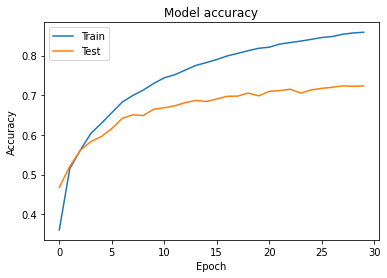

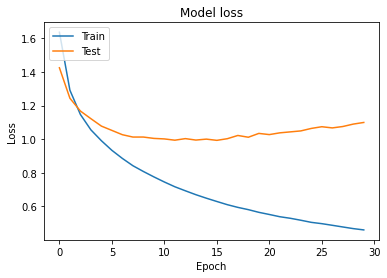

In [142]:
import matplotlib.pyplot as plt
# 绘制训练 
plt.plot(trainacc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(trainloss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()